# Manage Directories and Packages

In [1]:
# Uncomment this if you want to use Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/project/dataset/ssvep

chars  data_4s	raw  unigram_freq.csv  words


In [3]:
import os
import sys

# Go to main working directory
#os.makedirs('/content/eegnet-charrnn', exist_ok=True)
#%cd /content/eegnet-charrnn

# Directory containing subject files
subject_rawdata_dir = '/content/drive/MyDrive/project/dataset/ssvep/raw' # All raw .mat files should be here. Make sure to upload them!
subject_chars_dir = '/content/drive/MyDrive/project/dataset/ssvep/chars' # Where to store all character data
subject_words_dir = "/content/drive/MyDrive/project/dataset/ssvep/words" # Where to store all word data

os.makedirs(subject_rawdata_dir, exist_ok=True)
os.makedirs(subject_chars_dir, exist_ok=True)
os.makedirs(subject_words_dir, exist_ok=True)

In [4]:
#Install necessary packages
!pip install datasets
!pip install tensorflow==2.8.0
!pip install mne>=0.17.1 PyRiemann>=0.2.5 scikit-learn>=0.20.1 matplotlib>=2.2.3

!git clone https://github.com/vlawhern/arl-eegmodels.git
sys.path.append('/content/arl-eegmodels')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [5]:
# Import necessary libraries
import numpy as np
import string
import re
import json
import random
import gc
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tqdm import tqdm

from datasets import load_dataset
from scipy.io import loadmat
from scipy.signal import cheby1, filtfilt, resample

from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#load data and split

In [6]:
import itertools

def get_session_splits():
    all_sessions = [0, 1, 2, 3, 4, 5]
    session_splits = []

    for train_sessions in itertools.combinations(all_sessions, 4):
        remaining = [s for s in all_sessions if s not in train_sessions]
        val_session = remaining[0]
        test1_session = remaining[1]
        session_splits.append({
            'train': list(train_sessions),
            'val': val_session,
            'test1': test1_session
        })
    return session_splits

def load_data_by_session_split(subject_list, root_dir, session_split):
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test1, y_test1 = [], []

    for sid in subject_list:
        data = np.load(os.path.join(root_dir, f"S{sid}_chars.npy"))  # [26, 6, 64, 250]

        for c in range(26):
            for s in session_split['train']:
                X_train.append(data[c, s])
                y_train.append(c)
            X_val.append(data[c, session_split['val']])
            y_val.append(c)
            X_test1.append(data[c, session_split['test1']])
            y_test1.append(c)

    def preprocess(X, y):
        X = np.array(X)[..., np.newaxis]  # shape: [N, 64, 250, 1]
        y = to_categorical(np.array(y), num_classes=26)
        return X, y

    return preprocess(X_train, y_train), preprocess(X_val, y_val), preprocess(X_test1, y_test1)


In [7]:
subject_chars_dir = '/content/drive/MyDrive/project/dataset/ssvep/chars' # Where to store all character data
subject_ids = list(range(1, 36)) #35 samples + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
batch_size2 = 260
seed = 44
shuffle = True

# EEGNet

In [13]:
# Creating an EEGNet model
#eegnet_model = EEGNet(nb_classes=40, Chans=64, Samples=250, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')
eegnet_model = EEGNet(nb_classes=26, Chans=64, Samples=250, dropoutRate=0.2, kernLength=64, F1=16, D=2, F2=32, dropoutType='Dropout')

eegnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

eegnet_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 64, 250, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 250, 16)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 64, 250, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_16             │ (None, 1, 250, 32)     │         2,048 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 1, 250, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 1, 250, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_32            │ (None, 1, 62, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 1, 62, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_16             │ (None, 1, 62, 32)      │         1,536 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 1, 62, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 1, 62, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_33            │ (None, 1, 7, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 26)             │         5,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 26)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,778 (42.10 KB)

 Trainable params: 10,618 (41.48 KB)

 Non-trainable params: 160 (640.00 B)

First, randomly select 33 subjects as seen subjects, and assign the remaining 2 subjects as unseen subjects. Then, perform k-fold cross-validation at the session level.

Each time, for a given subject:

- Use 4 out of 6 sessions for training  
- Use 1 session for validation  
- Use 1 session for Test1

There are  
$\binom{6}{4} = 15$  
such combinations per subject (i.e., up to 15-fold cross-validation with the same requirement).

| Dataset | Subjects Used         | Sessions Used     |
|---------|------------------------|--------------------|
| Train   | 33 seen subjects       | [0, 1, 2, 3]       |
| Val     | Same 33 seen subjects  | [4]               |
| Test1   | Same 33 seen subjects  | [5]               |
| Test2   | 2 unseen subjects      | [0, 1, 2, 3, 4, 5] |


In [14]:
# KFold with 15 splits
# Loop through each fold
all_histories = []

session_splits = get_session_splits()
all_subjects = list(range(1, 36))
random.seed(42)
seen_subjects = random.sample(all_subjects, 33)
unseen_subjects = [s for s in all_subjects if s not in seen_subjects]

val_accs, test1_accs, test2_accs = [], [], []

for fold, sess_split in enumerate(session_splits):
    print(f"\n===== Fold {fold+1} / {len(session_splits)} =====")

    (X_train, y_train), (X_val, y_val), (X_test1, y_test1) = load_data_by_session_split(
        seen_subjects, subject_chars_dir, sess_split)

    # test2 固定
    X_test2, y_test2 = [], []
    for sid in unseen_subjects:
        data = np.load(os.path.join(subject_chars_dir, f"S{sid}_chars.npy"))
        for c in range(26):
            for s in range(6):
                X_test2.append(data[c, s])
                y_test2.append(c)
    X_test2 = np.array(X_test2)[..., np.newaxis]
    y_test2 = to_categorical(np.array(y_test2), 26)

    # 模型训练
    model = EEGNet(nb_classes=26, Chans=64, Samples=250, dropoutRate=0.2, kernLength=64, F1=16, D=2, F2=32, dropoutType='Dropout')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50, batch_size=32, verbose=0)
    all_histories.append(history.history)

    # 评估
    acc_val = model.evaluate(X_val, y_val, verbose=0)[1]
    acc_test1 = model.evaluate(X_test1, y_test1, verbose=0)[1]
    acc_test2 = model.evaluate(X_test2, y_test2, verbose=0)[1]

    print(f"[Fold {fold+1}] Val Acc: {acc_val:.4f}, Test1 Acc: {acc_test1:.4f}, Test2 Acc: {acc_test2:.4f}")
    val_accs.append(acc_val)
    test1_accs.append(acc_test1)
    test2_accs.append(acc_test2)

print("\n===== Summary =====")
print(f"Avg Val Acc   : {np.mean(val_accs):.4f}")
print(f"Avg Test1 Acc : {np.mean(test1_accs):.4f}")
print(f"Avg Test2 Acc : {np.mean(test2_accs):.4f}")



===== Fold 1 / 15 =====
[Fold 1] Val Acc: 0.8776, Test1 Acc: 0.8834, Test2 Acc: 0.8590

===== Fold 2 / 15 =====
[Fold 2] Val Acc: 0.8695, Test1 Acc: 0.8846, Test2 Acc: 0.8109

===== Fold 3 / 15 =====
[Fold 3] Val Acc: 0.8823, Test1 Acc: 0.8869, Test2 Acc: 0.8237

===== Fold 4 / 15 =====
[Fold 4] Val Acc: 0.8881, Test1 Acc: 0.8683, Test2 Acc: 0.8013

===== Fold 5 / 15 =====
[Fold 5] Val Acc: 0.8601, Test1 Acc: 0.8508, Test2 Acc: 0.7724

===== Fold 6 / 15 =====
[Fold 6] Val Acc: 0.8893, Test1 Acc: 0.8555, Test2 Acc: 0.7724

===== Fold 7 / 15 =====
[Fold 7] Val Acc: 0.8869, Test1 Acc: 0.8660, Test2 Acc: 0.7660

===== Fold 8 / 15 =====
[Fold 8] Val Acc: 0.9056, Test1 Acc: 0.8578, Test2 Acc: 0.7981

===== Fold 9 / 15 =====
[Fold 9] Val Acc: 0.8566, Test1 Acc: 0.8427, Test2 Acc: 0.7885

===== Fold 10 / 15 =====
[Fold 10] Val Acc: 0.8928, Test1 Acc: 0.8834, Test2 Acc: 0.8077

===== Fold 11 / 15 =====
[Fold 11] Val Acc: 0.8823, Test1 Acc: 0.8788, Test2 Acc: 0.8013

===== Fold 12 / 15 =====
[F

In [15]:
# Save current model
eegnet_model.save_weights("first_try_char_no_aug.weights.h5")

In [16]:
train_accuracies = history.history['accuracy']         # 或 'acc'，取决于版本
val_accuracies   = history.history['val_accuracy']
train_losses     = history.history['loss']
val_losses       = history.history['val_loss']
print(train_accuracies[:5])
print(val_losses[:5])

[0.06235431134700775, 0.11800698935985565, 0.20512820780277252, 0.3030303120613098, 0.41171327233314514]
[3.1871280670166016, 2.939063787460327, 2.4826080799102783, 1.999938726425171, 1.6767433881759644]


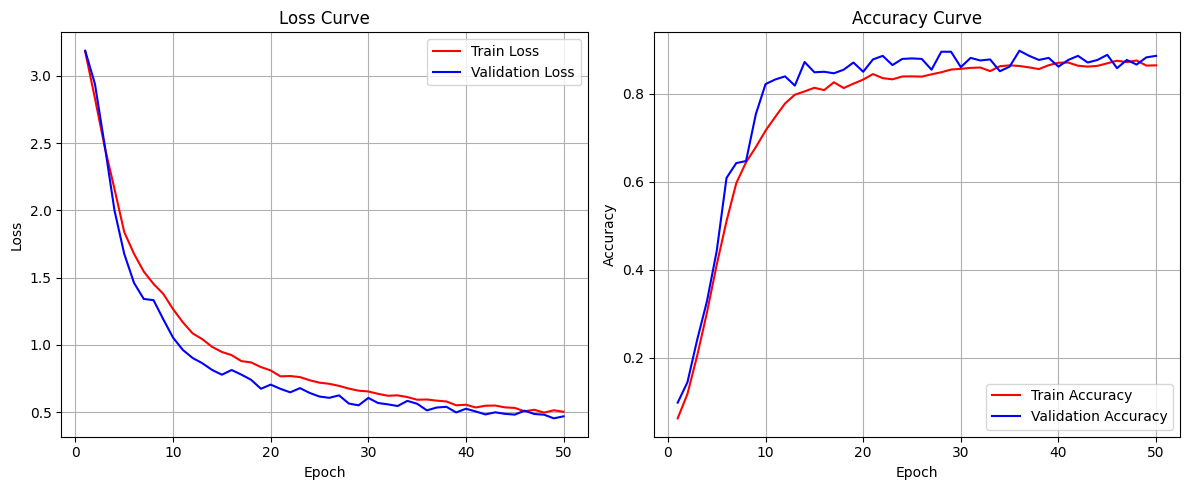

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label='Train Loss')
plt.plot(epochs, val_losses, 'b-', label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'b-', label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


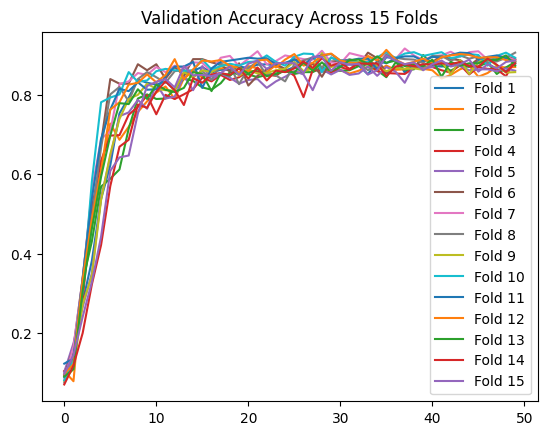

In [18]:
for i, h in enumerate(all_histories):
    plt.plot(h['val_accuracy'], label=f'Fold {i+1}')
plt.legend()
plt.title("Validation Accuracy Across 15 Folds")
plt.show()